In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Setup of the modified version of the 118bus system

Setup of the system:
- Define synchronous generation and converter-interfaced generation installed capacity
- Define peak and minimum load demand
- Define lines and transformers ratings
- Define system topology

The topology of the system is the one of the 118bus system studied in the REE project:
- Actual number of buses = 113
- Number of generation units = 28
- Each generation unit has a synchronous generator, a grid-following converter, and a grid-forming converter

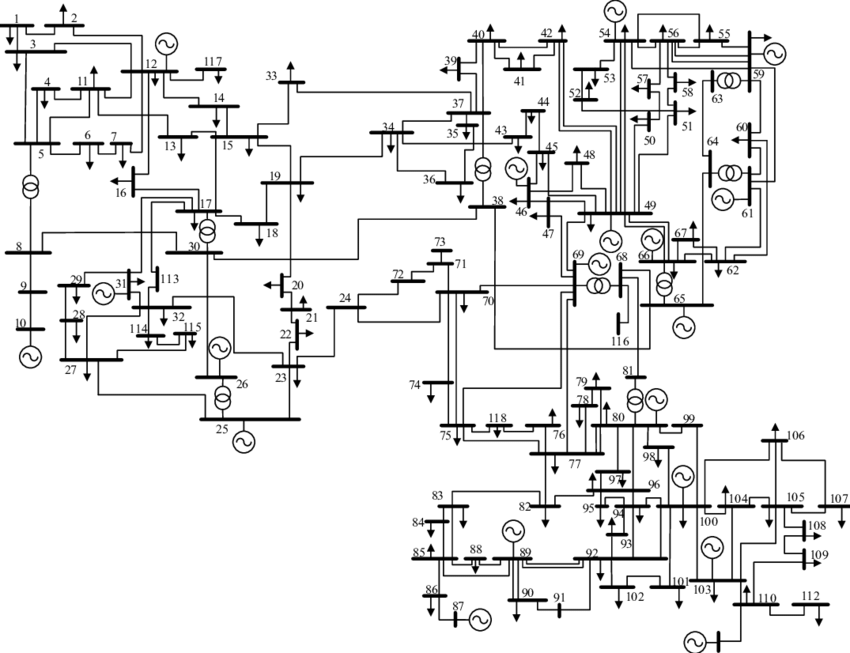 
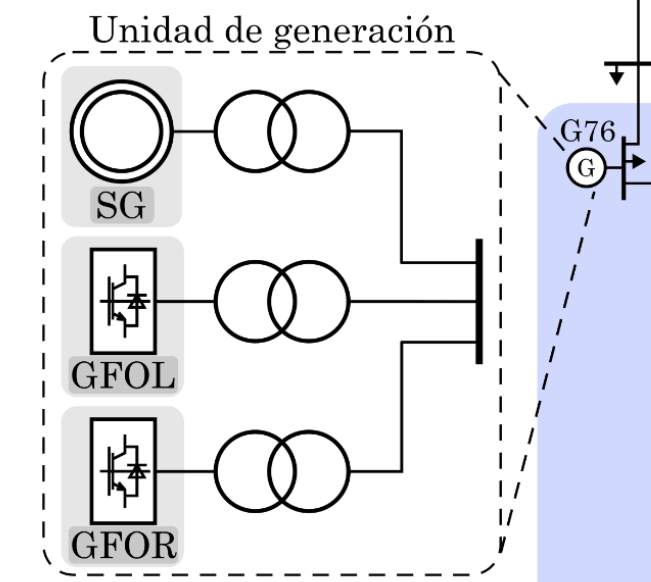

Generation capacity, demand range, and elements ratings are obtained by adapting the data provided by NREL in [1]. Such data cannot be directly applied to our 118 bus system (but need to be rearranged), as the NREL 118bus system presents different characteristics:
- Actual number of buses = 118
- Number of generation units = 54
- Not all the generation unit have converter-interfaced generation
- Very large generation capacity, leading problems to power flow convergence

The following part of the notebook at first shows the setup of the NREL 118bus system. Then, it explains how data of the NREL 118bus system have been adapted to our REE system.

## References
[1] Pena, Ivonne, Carlo Brancucci Martinez-Anido, and Bri-Mathias Hodge. "An extended IEEE 118-bus test system with high renewable penetration." IEEE Transactions on Power Systems 33.1 (2017): 281-289.


## NREL-118bus System 
### Buses


In [2]:
Buses=pd.read_csv('Buses.csv')
Buses

,Bus Name,Region,Load Participation Factor
0,bus026,R1,0.000000
1,bus010,R1,0.000000
2,bus025,R1,0.000000
3,bus012,R1,0.043466
4,bus015,R1,0.083238
...,...,...,...
113,bus093,R3,0.016137
114,bus084,R3,0.014792
115,bus109,R3,0.010758
116,bus102,R3,0.006724


In [4]:
for i in range(len(Buses)):
    Buses.loc[i,'Num']=int(Buses.loc[i,'Bus Name'][3:])

Buses=Buses.sort_values(by='Bus Name').reset_index(drop=True)

#pd.DataFrame.to_excel(Buses,'G:/Il mio Drive/Francesca 118 v2/Operation/tool_ree/tool_ree/Buses.xlsx')

Buses

,Bus Name,Region,Load Participation Factor,Num
0,bus001,R1,0.047169,1.0
1,bus002,R1,0.018496,2.0
2,bus003,R1,0.036069,3.0
3,bus004,R1,0.027749,4.0
4,bus005,R1,0.000000,5.0
...,...,...,...,...
113,bus114,R1,0.007397,114.0
114,bus115,R1,0.020343,115.0
115,bus116,R2,0.000000,116.0
116,bus117,R1,0.018496,117.0


### Loads
Hourly load consumption for one year, aggregated for system's region

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


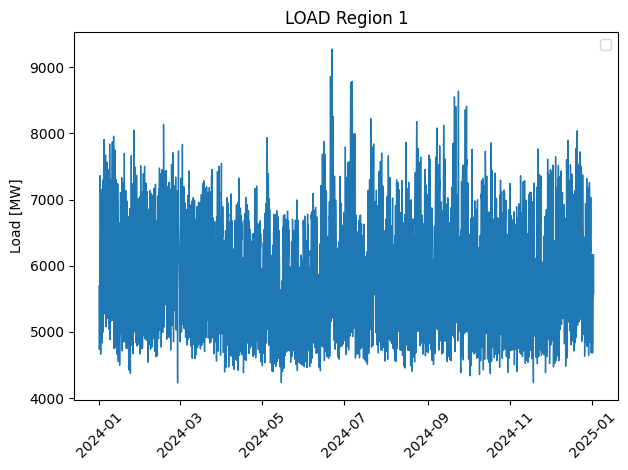

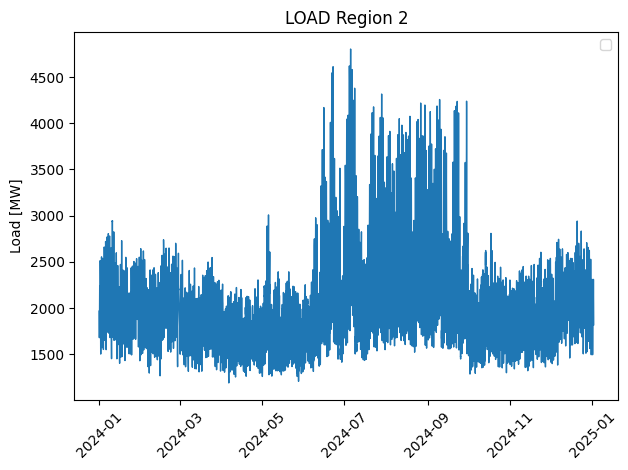

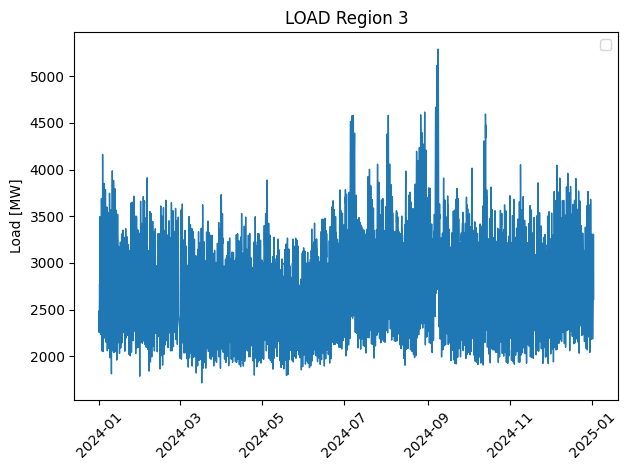

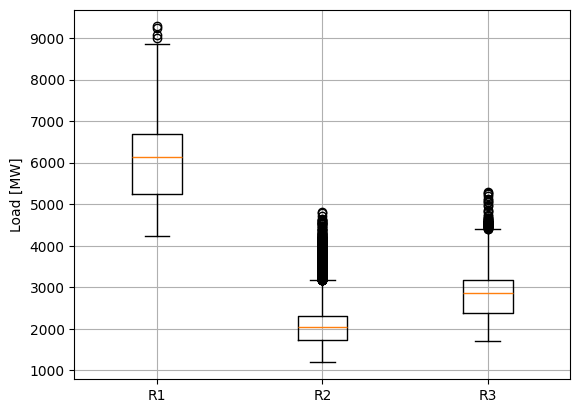

In [12]:
Loads=pd.DataFrame()

for zone in [1,2,3]:

    Loads_R=pd.read_csv('G:/Il mio Drive/Francesca 118 v2/input-files/Input files/RT/Load/LoadR'+str(zone)+'RT.csv')
    
    Loads_R["DATETIME"] = pd.to_datetime(Loads_R["DATETIME"])
    
    Loads_R=Loads_R.set_index(["DATETIME"]).sort_index()
    
    Loads['R'+str(zone)]=Loads_R
        
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.plot(Loads_R.index,Loads_R['value'], linewidth=1)
    plt.legend()
    ax.set_title('LOAD Region '+str(zone))  
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    ax.set_ylabel('Load [MW]')
    fig.tight_layout()
    
fig=plt.figure()
ax=fig.add_subplot()
ax.boxplot(Loads)
ax.set_ylabel('Load [MW]')
plt.xticks([1, 2,3], list(Loads.columns))
ax.grid()


In [6]:
Buses=Buses.rename(columns={"Load Participation Factor": "Load_Participation_Factor"}) 
loads_nrel=Buses.query('Load_Participation_Factor !=0')

loads_nrel

,Bus Name,Region,Load_Participation_Factor,Num
0,bus001,R1,0.047169,1.0
1,bus002,R1,0.018496,2.0
2,bus003,R1,0.036069,3.0
3,bus004,R1,0.027749,4.0
5,bus006,R1,0.048092,6.0
...,...,...,...,...
111,bus112,R3,0.033619,112.0
113,bus114,R1,0.007397,114.0
114,bus115,R1,0.020343,115.0
116,bus117,R1,0.018496,117.0


### Generators

In [7]:
Generators=pd.read_excel('Generators_red.xlsx') #Reduced beacuse useless columns have been discarded

for i in range(len(Generators)):
    Generators.loc[i,'Num']=int(Generators.loc[i,'Node of connection'][4:])
    Generators.loc[i,'Type']=Generators.loc[i,'Generator Name'][:-3]
    bus_num=int(Generators.loc[i,'Node of connection'][4:])
    Generators.loc[i,'Generator Name'][:-3]
    Generators.loc[i,'Region']=list(Buses.query('Num == @bus_num')['Region'])[0]

Generators

,Generator Name,Node of connection,Category,Units,Max Capacity (MW),Commit,Min Stable Level (MW),Num,Type,Region
0,Biomass 01,node012,1. Committed DA,1,3.0,0,0.90,12.0,Biomass,R1
1,Biomass 02,node012,1. Committed DA,1,3.0,0,0.90,12.0,Biomass,R1
2,Biomass 03,node103,1. Committed DA,1,1.2,0,0.36,103.0,Biomass,R3
3,Biomass 04,node103,1. Committed DA,1,1.2,0,0.36,103.0,Biomass,R3
4,Biomass 05,node012,1. Committed DA,1,1.3,0,0.26,12.0,Biomass,R1
...,...,...,...,...,...,...,...,...,...,...
322,Wind 13,node031,Wind,1,58.7,1,0.00,31.0,Wind,R1
323,Wind 14,node100,Wind,1,400.0,1,0.00,100.0,Wind,R3
324,Wind 15,node082,Wind,1,50.0,1,0.00,82.0,Wind,R3
325,Wind 16,node082,Wind,1,149.5,1,0.00,82.0,Wind,R3


In [82]:
types_of_gens=Generators['Type'].unique()
print(types_of_gens)

['Biomass' 'CC NG' 'CT NG' 'CT Oil' 'Geo' 'Hydro' 'ICE NG' 'Solar'
 'ST Coal' 'ST NG' 'ST Other' 'Wind']


In [9]:
nodes_of_connections=Generators['Node of connection'].unique()
nodes_gen_cap=pd.DataFrame()
Generators=Generators.rename(columns={'Node of connection':'Node_of_connection'})
for n in range(0,len(nodes_of_connections)):
    node=nodes_of_connections[n]
    nodes_gen_cap.loc[n,'Node']=node
    nodes_gen_cap.loc[n,'Capacity']=sum(Generators.query('Node_of_connection == @node')['Max Capacity (MW)'])
    

Generators_NREL=pd.DataFrame()
for i in range(0,len(nodes_gen_cap)):
    Generators_NREL.loc[i,'BusNum']=int(nodes_gen_cap.loc[i,'Node'][4:])
    
Generators_NREL['Capacity [MW]']=nodes_gen_cap['Capacity']    
Generators_NREL

,BusNum,Capacity [MW]
0,12.0,1701.03
1,103.0,95.27
2,34.0,68.80
3,74.0,100.00
4,112.0,303.75
5,107.0,841.39
6,36.0,201.01
7,66.0,673.40
8,46.0,246.26
9,49.0,395.35


#### Wind, Solar, and Hydro Generation
Hourly generation (of each generator) for one year

In [10]:
from os import listdir
from os.path import isfile, join

def res_gen(res,df):
    path='./input-files/Input files/RT/'+res+'/'
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    onlyfiles=list(set(onlyfiles)-set(['.DS_Store']))
    
    for file in onlyfiles:
        df_i=pd.read_csv(path+file)
        
        df_i["DATETIME"] = pd.to_datetime(df_i["DATETIME"])
        
        df_i=df_i.set_index(["DATETIME"]).sort_index()
        
        df[file[:-6]]=df_i
        
    return df
           
Solar=pd.DataFrame()
Wind=pd.DataFrame()
Hydro=pd.DataFrame()
    
Solar=res_gen('Solar',Solar)
Wind=res_gen('Wind',Wind)
Hydro=res_gen('Hydro',Wind)

In [11]:
Wind

,Wind12,Wind16,Wind5,Wind11,Wind6,Wind7,Wind17,Wind2,Wind10,Wind9,Wind3,Wind14,Wind8,Wind13,Wind4,Wind15,Wind1,Hydro
DATETIME,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,0.822722,0.297516,0.902116,5.058859,0.877676,1.942837,9.669997,3.724274,12.765404,11.693075,2.477267,4.500030,13.847484,1.687492,0.769740,8.252688,0.458135,0.79587
2024-01-01 01:00:00,3.046363,0.051735,0.951623,9.208173,2.008854,4.622050,5.947432,8.090245,13.682279,12.962309,3.031204,6.411089,14.572063,4.078827,1.013277,8.222057,0.900835,13.73772
2024-01-01 02:00:00,9.545811,0.000000,0.904939,9.190788,2.794547,6.191502,3.205198,13.335597,12.681899,11.407550,3.089380,11.625729,13.677956,5.380704,0.506920,8.338495,2.412459,7.60737
2024-01-01 03:00:00,53.627804,1.635511,0.978896,9.695205,9.659556,9.045088,2.940856,23.850555,14.305784,13.585817,2.486115,26.558630,15.210591,26.623678,0.367775,9.373620,5.340160,7.45680
2024-01-01 04:00:00,51.880845,3.470530,0.906345,9.710853,10.975506,9.334108,0.815381,23.962612,12.569062,11.807606,2.629418,25.271533,14.149706,29.804588,0.349065,8.275774,5.856456,7.42095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 19:00:00,8.322766,10.629521,0.000000,0.000000,0.678839,0.000204,29.618573,0.000000,0.000000,0.000000,1.546054,14.386462,0.000000,2.388373,0.239122,27.048672,0.000780,56.44941
2025-01-01 20:00:00,4.277697,6.808885,0.000000,0.000407,0.702487,0.003298,8.286292,0.000000,0.000000,0.000000,3.779966,6.112000,0.000000,2.684599,0.730586,25.178994,0.002851,56.37054
2025-01-01 21:00:00,1.525636,4.329162,0.000000,0.000000,0.644244,0.003825,2.778807,0.000000,0.000000,0.001902,5.598673,1.310316,0.000000,1.392421,1.788015,23.885157,0.002244,56.31318


### Summary: regions description

In [16]:
NRES_SG=['CC NG', 'CT NG', 'CT Oil', 'ICE NG', 'ST Coal', 'ST NG', 'ST Other']
RES_SG=['Geo', 'Hydro','Biomass']
TOT_SG=['Geo', 'Hydro','Biomass', 'CC NG', 'CT NG', 'CT Oil', 'ICE NG', 'ST Coal', 'ST NG', 'ST Other']
CIG=['Wind','Solar']

reg_list=['R1','R2','R3']
regions=pd.DataFrame()
regions_gen_perc=pd.DataFrame()
for r in range(len(reg_list)):
    R=reg_list[r]
    regions.loc[r,'Region']=R
    regions_gen_perc.loc[r,'Region']=R
    buses_reg=list(np.array(Buses.query('Region == @R')['Num'],dtype=int))
    gen_reg=Generators.query('Num == @buses_reg')
    regions.loc[r,'N_gens']=len(gen_reg)    
    regions.loc[r,'Capacity (MW)']=sum(gen_reg['Max Capacity (MW)'])
    regions.loc[r,'Buses list']=str(buses_reg)
    regions.loc[r,'Num Bus']=len(buses_reg)
    regions.loc[r,'Peak Load (MW)']=Loads[R].max()
    regions.loc[r,'Min Load (MW)']=Loads[R].min()
    
    for t in types_of_gens:
        regions_gen_perc.loc[r,t]=sum(gen_reg.query('Type == @t')['Max Capacity (MW)'])/regions.loc[r,'Capacity (MW)']*100
        regions.loc[r,t]=sum(gen_reg.query('Type == @t')['Max Capacity (MW)'])
        
    regions.loc[r,'NRES_SG [MW]']= sum(regions.loc[r,NRES_SG])
    regions.loc[r,'RES_SG [MW]']= sum(regions.loc[r,RES_SG])
    regions.loc[r,'CIG [MW]']= sum(regions.loc[r,CIG])

    regions=regions.drop(types_of_gens,axis=1)

    regions_gen_perc.loc[r,'NRES_SG [MW]']= sum(regions_gen_perc.loc[r,NRES_SG])
    regions_gen_perc.loc[r,'RES_SG [MW]']= sum(regions_gen_perc.loc[r,RES_SG])
    regions_gen_perc.loc[r,'CIG [MW]']= sum(regions_gen_perc.loc[r,CIG])

    regions.loc[r,'NRES_SG [%]']= sum(regions_gen_perc.loc[r,NRES_SG])
    regions.loc[r,'RES_SG [%]']= sum(regions_gen_perc.loc[r,RES_SG])
    regions.loc[r,'CIG [%]']= sum(regions_gen_perc.loc[r,CIG])
    regions.loc[r,'TOT_SG [%]']= sum(regions_gen_perc.loc[r,NRES_SG+RES_SG])
    
regions

,Region,N_gens,Capacity (MW),Buses list,Num Bus,Peak Load (MW),Min Load (MW),NRES_SG [MW],RES_SG [MW],CIG [MW],NRES_SG [%],RES_SG [%],CIG [%],TOT_SG [%]
0,R1,136.0,10522.99,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",42.0,9276.327882,4228.311838,8929.07,59.05,1534.87,84.852974,0.561152,14.585873,85.414127
1,R2,72.0,21437.50,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...",48.0,4803.546377,1190.362815,2311.16,18681.97,444.37,10.780921,87.146216,2.072863,97.927137
2,R3,119.0,8557.63,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...",28.0,5290.274654,1715.314180,5967.03,46.17,2544.43,69.727600,0.539519,29.732882,70.267118


In [17]:
def pie_plot(y,labels,title,labels_flag):
    fig=plt.figure()
        
    if labels_flag:
        p, tx, autotexts = plt.pie(y, labels=labels,textprops={'fontsize': 20},
                autopct="", shadow=True)
        for i, a in enumerate(autotexts):
            a.set_text("{0:.0f}".format(np.array(y)[i]))
    else:
        p, tx, autotexts = plt.pie(y, textprops={'fontsize': 20},
                autopct="", shadow=True)
        plt.legend(labels)
        
    plt.title(title,fontsize=20)
    
    fig.tight_layout

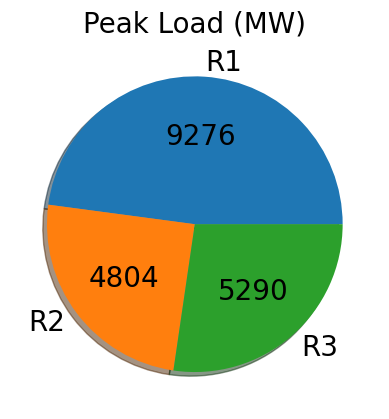

In [18]:
title='Peak Load (MW)'
y = regions[title]
mylabels = regions['Region']

pie_plot(y,mylabels,title,labels_flag=1)

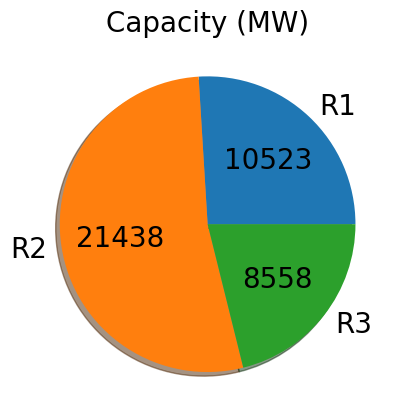

In [21]:
title='Capacity (MW)'
y = regions[title]
mylabels = regions['Region']

pie_plot(y,mylabels,title,labels_flag=1)

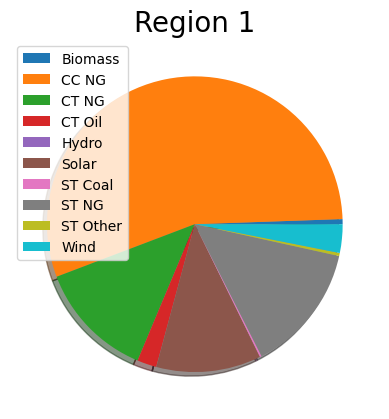

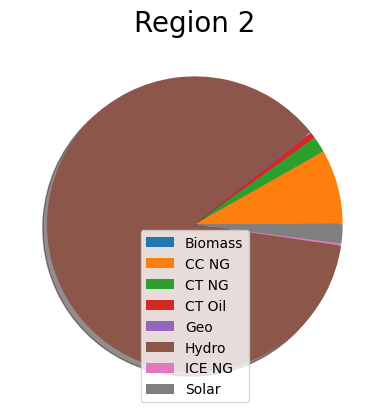

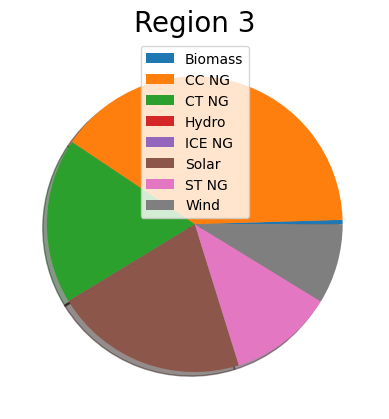

In [22]:
for r in range(1,len(reg_list)+1):
    title='Region '+str(r)
    y = regions_gen_perc.loc[r-1,types_of_gens][regions_gen_perc.loc[r-1,types_of_gens]!=0]
    mylabels = y.index
    
    pie_plot(y,mylabels,title,labels_flag=0)

## Our 118-System (REE system)
### Generators

In [83]:
from GridCalEngine.IO.file_handler import FileOpen

fname='IEEE118busREE_Winter_Solved_mod_PQ_91Loads.raw'
path='../../stability_analysis/stability_analysis/data/raw/'

main_circuit = FileOpen(path+fname).open()

# Generation buses in ree system
generators=main_circuit.get_generators()

Generators_GC=pd.DataFrame()
for g in range(len(generators)):
    Generators_GC.loc[g,'Bus Name']=generators[g].bus._name
    Generators_GC.loc[g,'BusNum']=int(generators[g].bus.code)

# assign to each generator bus in REE system the generators installed in the same bus of the NREL system    

types_of_gens=Generators['Type'].unique()

for g in range(len(Generators_GC)):
    bus_gen=Generators_GC.loc[g,'BusNum']
    Generators_GC.loc[g,'Region']=list(Buses.query('Num == @bus_gen')['Region'])[0]
    aa=Generators.query('Num == @bus_gen')
    for t in types_of_gens:
        Generators_GC.loc[g,t+' (MW)']=sum(aa.query('Type == @t')['Max Capacity (MW)'])

Generators_GC

,Bus Name,BusNum,Region,Biomass (MW),CC NG (MW),CT NG (MW),CT Oil (MW),Geo (MW),Hydro (MW),ICE NG (MW),Solar (MW),ST Coal (MW),ST NG (MW),ST Other (MW),Wind (MW)
0,TWINBRCH,12.0,R1,58.25,1642.78,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
1,LINCOLN,19.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,124.80,0.0,62.60,0.0,0.0
2,DEERCRK,31.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,156.2
3,DELAWARE,32.0,R1,0.00,0.00,0.00,0.0,0.0,0.80,0.00,751.61,0.0,0.00,0.0,0.0
4,ROCKHILL,34.0,R2,16.50,27.00,0.00,0.0,0.0,16.90,8.40,0.00,0.0,0.00,0.0,0.0
5,STERLING,36.0,R2,0.00,71.51,82.40,0.0,0.0,47.10,0.00,0.00,0.0,0.00,0.0,0.0
6,WEST END,40.0,R2,0.00,0.00,54.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
7,W.LANCST,46.0,R2,0.00,150.00,0.00,0.0,0.0,96.26,0.00,0.00,0.0,0.00,0.0,0.0
8,PHILO,49.0,R2,0.00,262.95,50.40,0.0,0.0,82.00,0.00,0.00,0.0,0.00,0.0,0.0
9,TORREY,54.0,R2,0.00,0.00,0.00,142.4,0.0,0.00,0.00,264.47,0.0,0.00,0.0,0.0


In [84]:
# Generation buses that are in REE system but not in NREL system
gen_bus_GC_not_in_NREL=list(set(Generators_GC['BusNum'])-set(Generators_NREL['BusNum']))

gen_bus_GC_not_in_NREL

[73.0]

In [85]:
# Generation buses that are in NREL system but not in REE system
gen_bus_NREL_not_in_GC=list(set(Generators_NREL['BusNum'])-set(Generators_GC['BusNum']))
gen_bus_NREL_not_in_GC

[4.0,
 6.0,
 8.0,
 10.0,
 15.0,
 18.0,
 24.0,
 25.0,
 26.0,
 27.0,
 42.0,
 55.0,
 56.0,
 61.0,
 62.0,
 66.0,
 69.0,
 74.0,
 82.0,
 87.0,
 91.0,
 99.0,
 103.0,
 104.0,
 111.0,
 116.0]

In [86]:
# replace the generators buses that are in REE system but not in NREL system with some of the NREL:
#assign to gen at bus 73 of REE system the gen at bus 74 of NREL system
Generators_GC.loc[Generators_GC.query('BusNum == 73').index,'Region']=list(Buses.query('Num == 74')['Region'])[0]  
aa=Generators.query('Num == 74')
for t in types_of_gens:
    Generators_GC.loc[Generators_GC.query('BusNum == 73').index,t+' (MW)']=sum(aa.query('Type == @t')['Max Capacity (MW)'])

Generators_GC


,Bus Name,BusNum,Region,Biomass (MW),CC NG (MW),CT NG (MW),CT Oil (MW),Geo (MW),Hydro (MW),ICE NG (MW),Solar (MW),ST Coal (MW),ST NG (MW),ST Other (MW),Wind (MW)
0,TWINBRCH,12.0,R1,58.25,1642.78,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
1,LINCOLN,19.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,124.80,0.0,62.60,0.0,0.0
2,DEERCRK,31.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,156.2
3,DELAWARE,32.0,R1,0.00,0.00,0.00,0.0,0.0,0.80,0.00,751.61,0.0,0.00,0.0,0.0
4,ROCKHILL,34.0,R2,16.50,27.00,0.00,0.0,0.0,16.90,8.40,0.00,0.0,0.00,0.0,0.0
5,STERLING,36.0,R2,0.00,71.51,82.40,0.0,0.0,47.10,0.00,0.00,0.0,0.00,0.0,0.0
6,WEST END,40.0,R2,0.00,0.00,54.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0
7,W.LANCST,46.0,R2,0.00,150.00,0.00,0.0,0.0,96.26,0.00,0.00,0.0,0.00,0.0,0.0
8,PHILO,49.0,R2,0.00,262.95,50.40,0.0,0.0,82.00,0.00,0.00,0.0,0.00,0.0,0.0
9,TORREY,54.0,R2,0.00,0.00,0.00,142.4,0.0,0.00,0.00,264.47,0.0,0.00,0.0,0.0


In [87]:
NRES_SG=['CC NG (MW)', 'CT NG (MW)', 'CT Oil (MW)', 'ICE NG (MW)', 'ST Coal (MW)', 'ST NG (MW)', 'ST Other (MW)']
RES_SG=['Geo (MW)', 'Hydro (MW)','Biomass (MW)']
TOT_SG=['Geo (MW)', 'Hydro (MW)','Biomass (MW)', 'CC NG (MW)', 'CT NG (MW)', 'CT Oil (MW)', 'ICE NG (MW)', 'ST Coal (MW)', 'ST NG (MW)', 'ST Other (MW)']
CIG=['Wind (MW)','Solar (MW)']

Generators_GC['NRES_SG']=Generators_GC[NRES_SG].sum(axis=1)
Generators_GC['RES_SG']=Generators_GC[RES_SG].sum(axis=1)
Generators_GC['Pmax_TOT_SG']=Generators_GC[TOT_SG].sum(axis=1)
Generators_GC['Pmax_CIG']=Generators_GC[CIG].sum(axis=1)
Generators_GC['Pmax_TOT']=Generators_GC['Pmax_CIG']+Generators_GC['Pmax_TOT_SG']
Generators_GC

,Bus Name,BusNum,Region,Biomass (MW),CC NG (MW),CT NG (MW),CT Oil (MW),Geo (MW),Hydro (MW),ICE NG (MW),Solar (MW),ST Coal (MW),ST NG (MW),ST Other (MW),Wind (MW),NRES_SG,RES_SG,Pmax_TOT_SG,Pmax_CIG,Pmax_TOT
0,TWINBRCH,12.0,R1,58.25,1642.78,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,1642.78,58.25,1701.03,0.00,1701.03
1,LINCOLN,19.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,124.80,0.0,62.60,0.0,0.0,62.60,0.00,62.60,124.80,187.40
2,DEERCRK,31.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,156.2,0.00,0.00,0.00,156.20,156.20
3,DELAWARE,32.0,R1,0.00,0.00,0.00,0.0,0.0,0.80,0.00,751.61,0.0,0.00,0.0,0.0,0.00,0.80,0.80,751.61,752.41
4,ROCKHILL,34.0,R2,16.50,27.00,0.00,0.0,0.0,16.90,8.40,0.00,0.0,0.00,0.0,0.0,35.40,33.40,68.80,0.00,68.80
5,STERLING,36.0,R2,0.00,71.51,82.40,0.0,0.0,47.10,0.00,0.00,0.0,0.00,0.0,0.0,153.91,47.10,201.01,0.00,201.01
6,WEST END,40.0,R2,0.00,0.00,54.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,54.00,0.00,54.00,0.00,54.00
7,W.LANCST,46.0,R2,0.00,150.00,0.00,0.0,0.0,96.26,0.00,0.00,0.0,0.00,0.0,0.0,150.00,96.26,246.26,0.00,246.26
8,PHILO,49.0,R2,0.00,262.95,50.40,0.0,0.0,82.00,0.00,0.00,0.0,0.00,0.0,0.0,313.35,82.00,395.35,0.00,395.35
9,TORREY,54.0,R2,0.00,0.00,0.00,142.4,0.0,0.00,0.00,264.47,0.0,0.00,0.0,0.0,142.40,0.00,142.40,264.47,406.87


Some generation units do not have CIG. Therefore, to these unit it is assigned the CIG installed capacity of some CIG of the NREL system, not present in REE system.

In [30]:
missing_gen=pd.DataFrame()
m_gen_list=list(set(Generators['Num'].unique())-set(Generators_GC['BusNum'].unique()))
missing_gen['Bus Num']=m_gen_list
    
missing_gen['Region']=list(Buses.query('Num == @m_gen_list')['Region'])
missing_gen


,Bus Num,Region
0,4.0,R1
1,6.0,R1
2,8.0,R1
3,10.0,R1
4,15.0,R1
5,18.0,R1
6,24.0,R1
7,25.0,R1
8,26.0,R1
9,27.0,R1


In [31]:
#%% type of generator in the missing generation buses

for ii in range(0,len(missing_gen)):
    gen=missing_gen.loc[ii,'Bus Num']
    types=Generators.query('Num == @gen')['Type'].unique()
    for gen_type in types:
        missing_gen.loc[ii,gen_type]=Generators.query('Num == @gen and Type == @gen_type')['Max Capacity (MW)'].sum()

#capacity of the cig installed in the missing generation buses
missing_cig=missing_gen[['Region','Bus Num','Wind','Solar']]
#cig installed in the ree generation buses
gen_GC_cig=Generators_GC[['Region','BusNum','Wind (MW)','Solar (MW)']].sort_values(by='Region').reset_index(drop=True)
gen_GC_cig['CIG']=gen_GC_cig['Wind (MW)']+gen_GC_cig['Solar (MW)']

bus_num_GC=list(Generators_GC['BusNum'])
generators_nrel_cig_missing=Generators.query('Type == "Wind" or Type == "Solar" and Num != @bus_num_GC')
generators_nrel_cig_missing

,Generator Name,Node_of_connection,Category,Units,Max Capacity (MW),Commit,Min Stable Level (MW),Num,Type,Region
226,Solar 05,node018,Solar,1,0.12,1,0.0,18.0,Solar,R1
227,Solar 06,node018,Solar,1,6.33,1,0.0,18.0,Solar,R1
228,Solar 07,node018,Solar,1,0.21,1,0.0,18.0,Solar,R1
229,Solar 08,node018,Solar,1,2.51,1,0.0,18.0,Solar,R1
230,Solar 09,node018,Solar,1,12.85,1,0.0,18.0,Solar,R1
231,Solar 10,node015,Solar,1,9.71,1,0.0,15.0,Solar,R1
232,Solar 11,node015,Solar,1,1.98,1,0.0,15.0,Solar,R1
233,Solar 12,node015,Solar,1,1.54,1,0.0,15.0,Solar,R1
234,Solar 13,node015,Solar,1,0.26,1,0.0,15.0,Solar,R1
235,Solar 14,node015,Solar,1,11.71,1,0.0,15.0,Solar,R1


In [32]:
n_cig_missing_gc_reg=len(gen_GC_cig.query('CIG==0'))

n_cig_gen_x_bus=int(np.ceil(len(generators_nrel_cig_missing)/n_cig_missing_gc_reg))

jj=0
for ii in gen_GC_cig.query('CIG==0').index:#len(generators_nrel_cig_missing_reg),n_cig_gen_x_bus):
    
    try:
        gens_cap=generators_nrel_cig_missing.loc[generators_nrel_cig_missing.index[jj:jj+n_cig_gen_x_bus],['Generator Name','Max Capacity (MW)','Category']]
    except:
        gens_cap=generators_nrel_cig_missing.loc[generators_nrel_cig_missing.index[jj:],['Generator Name','Max Capacity (MW)','Category']]
        
    for cat in gens_cap['Category'].unique():
        gen_GC_cig.loc[ii,cat+' (MW)']=gens_cap.query('Category ==@cat')['Max Capacity (MW)'].sum()
    
    gen_GC_cig.loc[ii,'Added Gens']=str(list(gens_cap['Generator Name']))
    
    jj=jj+n_cig_gen_x_bus

gen_GC_cig['CIG']=gen_GC_cig['Wind (MW)']+gen_GC_cig['Solar (MW)']

In [33]:
gen_GC_cig

,Region,BusNum,Wind (MW),Solar (MW),CIG,Added Gens
0,R1,12.0,0.0,6.66,6.66,"['Solar 05', 'Solar 06', 'Solar 07']"
1,R1,73.0,0.0,25.07,25.07,"['Solar 08', 'Solar 09', 'Solar 10']"
2,R1,70.0,0.0,3.78,3.78,"['Solar 11', 'Solar 12', 'Solar 13']"
3,R1,72.0,0.0,28.84,28.84,"['Solar 14', 'Solar 15', 'Solar 16']"
4,R1,113.0,0.0,15.46,15.46,"['Solar 17', 'Solar 18', 'Solar 19']"
5,R1,32.0,0.0,751.61,751.61,nan
6,R1,19.0,0.0,124.80,124.80,nan
7,R1,31.0,156.2,0.00,156.20,nan
8,R2,80.0,0.0,37.48,37.48,"['Solar 20', 'Solar 21', 'Solar 22']"
9,R2,77.0,0.0,3.68,3.68,"['Solar 23', 'Solar 24', 'Solar 25']"


In [34]:
#%% put the added cig capacity in the general Generators_GC df
for bus in gen_GC_cig['BusNum']:
    bus= int(bus)
    Generators_GC.loc[Generators_GC.query('BusNum == @bus').index,'Solar (MW)']=gen_GC_cig.loc[gen_GC_cig.query('BusNum == @bus').index[0],'Solar (MW)']
    Generators_GC.loc[Generators_GC.query('BusNum == @bus').index,'Wind (MW)']=gen_GC_cig.loc[gen_GC_cig.query('BusNum == @bus').index[0],'Wind (MW)']
    
Generators_GC['Pmax_CIG']=Generators_GC[CIG].sum(axis=1)
Generators_GC['Pmax_TOT']=Generators_GC['Pmax_CIG']+Generators_GC['Pmax_TOT_SG']
Generators_GC

,Bus Name,BusNum,Region,Biomass (MW),CC NG (MW),CT NG (MW),CT Oil (MW),Geo (MW),Hydro (MW),ICE NG (MW),Solar (MW),ST Coal (MW),ST NG (MW),ST Other (MW),Wind (MW),NRES_SG,RES_SG,Pmax_TOT_SG,Pmax_CIG,Pmax_TOT
0,TWINBRCH,12.0,R1,58.25,1642.78,0.00,0.0,0.0,0.00,0.00,6.66,0.0,0.00,0.0,0.0,1642.78,58.25,1701.03,6.66,1707.69
1,LINCOLN,19.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,124.80,0.0,62.60,0.0,0.0,62.60,0.00,62.60,124.80,187.40
2,DEERCRK,31.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,156.2,0.00,0.00,0.00,156.20,156.20
3,DELAWARE,32.0,R1,0.00,0.00,0.00,0.0,0.0,0.80,0.00,751.61,0.0,0.00,0.0,0.0,0.00,0.80,0.80,751.61,752.41
4,ROCKHILL,34.0,R2,16.50,27.00,0.00,0.0,0.0,16.90,8.40,129.16,0.0,0.00,0.0,0.0,35.40,33.40,68.80,129.16,197.96
5,STERLING,36.0,R2,0.00,71.51,82.40,0.0,0.0,47.10,0.00,0.00,0.0,0.00,0.0,59.5,153.91,47.10,201.01,59.50,260.51
6,WEST END,40.0,R2,0.00,0.00,54.00,0.0,0.0,0.00,0.00,95.00,0.0,0.00,0.0,0.0,54.00,0.00,54.00,95.00,149.00
7,W.LANCST,46.0,R2,0.00,150.00,0.00,0.0,0.0,96.26,0.00,244.40,0.0,0.00,0.0,0.0,150.00,96.26,246.26,244.40,490.66
8,PHILO,49.0,R2,0.00,262.95,50.40,0.0,0.0,82.00,0.00,350.97,0.0,0.00,0.0,0.0,313.35,82.00,395.35,350.97,746.32
9,TORREY,54.0,R2,0.00,0.00,0.00,142.4,0.0,0.00,0.00,264.47,0.0,0.00,0.0,0.0,142.40,0.00,142.40,264.47,406.87


In [89]:
#%% REE regions
reg_list=['R1','R2','R3']
regions_GC=pd.DataFrame()
regions_GC_gen_perc=pd.DataFrame()
for r in range(len(reg_list)):
    R=reg_list[r]
    regions_GC.loc[r,'Region']=R
    regions_GC_gen_perc.loc[r,'Region']=R
    buses_reg=list(np.array(Generators_GC.query('Region == @R')['BusNum'],dtype=int))
    gen_reg=Generators_GC.query('Region == @R')
    regions_GC.loc[r,'N_gens']=(gen_reg[TOT_SG+CIG]!=0).sum().sum()
    regions_GC.loc[r,'Capacity (MW)']=gen_reg[TOT_SG].sum().sum()+gen_reg[CIG].sum().sum()
    regions_GC.loc[r,'Buses list']=str(buses_reg)
    regions_GC.loc[r,'Num Bus']=len(buses_reg)
     
    for t in TOT_SG+CIG:
        regions_GC_gen_perc.loc[r,t]=sum(gen_reg[t])/regions_GC.loc[r,'Capacity (MW)']*100
        regions_GC.loc[r,t]=sum(gen_reg[t])
        
    regions_GC_gen_perc.loc[r,'NRES_SG [%]']= sum(regions_GC_gen_perc.loc[r,NRES_SG])
    regions_GC_gen_perc.loc[r,'RES_SG [%]']= sum(regions_GC_gen_perc.loc[r,RES_SG])
    regions_GC_gen_perc.loc[r,'CIG [%]']= sum(regions_GC_gen_perc.loc[r,CIG])

    regions_GC.loc[r,'NRES_SG [MW]']= sum(regions_GC.loc[r,NRES_SG])
    regions_GC.loc[r,'RES_SG [MW]']= sum(regions_GC.loc[r,RES_SG])
    regions_GC.loc[r,'CIG [MW]']= sum(regions_GC.loc[r,CIG])

    regions_GC=regions_GC.drop(TOT_SG+CIG,axis=1)

    regions_GC.loc[r,'NRES_SG [%]']= sum(regions_GC_gen_perc.loc[r,NRES_SG])
    regions_GC.loc[r,'RES_SG [%]']= sum(regions_GC_gen_perc.loc[r,RES_SG])
    regions_GC.loc[r,'CIG [%]']= sum(regions_GC_gen_perc.loc[r,CIG])
    regions_GC.loc[r,'TOT_SG [%]']= sum(regions_GC_gen_perc.loc[r,NRES_SG+RES_SG])

regions_GC

,Region,N_gens,Capacity (MW),Buses list,Num Bus,NRES_SG [MW],RES_SG [MW],CIG [MW],NRES_SG [%],RES_SG [%],CIG [%],TOT_SG [%]
0,R1,11.0,4161.04,"[12, 19, 31, 32, 70, 72, 73, 113]",8.0,3069.38,59.05,1032.61,73.764732,1.419116,24.816152,75.183848
1,R2,24.0,9784.04,"[34, 36, 40, 46, 49, 54, 59, 65, 76, 77, 80]",11.0,1518.66,7975.91,289.47,15.521809,81.519597,2.958594,97.041406
2,R3,20.0,5654.06,"[85, 89, 90, 92, 100, 105, 107, 110, 112]",9.0,3919.63,6.00,1728.43,69.324167,0.106118,30.569715,69.430285


In [90]:
headers=regions_GC_gen_perc.columns
headers2=[i.replace('(MW)','[%]') for i in headers]
regions_GC_gen_perc.columns=headers2
regions_GC_gen_perc

,Region,Geo [%],Hydro [%],Biomass [%],CC NG [%],CT NG [%],CT Oil [%],ICE NG [%],ST Coal [%],ST NG [%],ST Other [%],Wind [%],Solar [%],NRES_SG [%],RES_SG [%],CIG [%]
0,R1,0.0,0.019226,1.399890,56.759368,0.000000,0.000000,0.000000,0.0,17.005364,0.0,3.753869,21.062283,73.764732,1.419116,24.816152
1,R2,0.0,81.350955,0.168642,11.727875,1.909232,1.455431,0.429271,0.0,0.000000,0.0,0.000000,2.958594,15.521809,81.519597,2.958594
2,R3,0.0,0.106118,0.000000,35.810197,16.152994,0.000000,0.057481,0.0,17.303495,0.0,7.074562,23.495152,69.324167,0.106118,30.569715


In [91]:
#%% Summary of NREL regions
regions

,Region,N_gens,Capacity (MW),Buses list,Num Bus,Peak Load (MW),Min Load (MW),NRES_SG [MW],RES_SG [MW],CIG [MW],NRES_SG [%],RES_SG [%],CIG [%],TOT_SG [%]
0,R1,136.0,10522.99,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",42.0,9276.327882,4228.311838,8929.07,59.05,1534.87,84.852974,0.561152,14.585873,85.414127
1,R2,72.0,21437.50,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...",48.0,4803.546377,1190.362815,2311.16,18681.97,444.37,10.780921,87.146216,2.072863,97.927137
2,R3,119.0,8557.63,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...",28.0,5290.274654,1715.314180,5967.03,46.17,2544.43,69.727600,0.539519,29.732882,70.267118


Proporcionate the load peak and minimum demand od NREL system to the capacity of the REE system.

In [92]:
#%% reduced capacity in percentage

cap_ree=regions_GC['Capacity (MW)']
cap_nrel=regions['Capacity (MW)']
print('REE system capacity = {%f} NREL system capacity',cap_ree/cap_nrel)

peak_load_nrel=regions['Peak Load (MW)']
min_load_nrel=regions['Min Load (MW)']

peak_load_ree=peak_load_nrel*cap_ree/cap_nrel
min_load_ree=min_load_nrel*cap_ree/cap_nrel

regions_GC['Peak Load (MW)']=peak_load_ree
regions_GC['Min Load (MW)']=min_load_ree

regions_GC

REE system capacity = {%f} NREL system capacity 0    0.395424
1    0.456398
2    0.660704
Name: Capacity (MW), dtype: float64


,Region,N_gens,Capacity (MW),Buses list,Num Bus,NRES_SG [MW],RES_SG [MW],CIG [MW],NRES_SG [%],RES_SG [%],CIG [%],TOT_SG [%],Peak Load (MW),Min Load (MW)
0,R1,11.0,4161.04,"[12, 19, 31, 32, 70, 72, 73, 113]",8.0,3069.38,59.05,1032.61,73.764732,1.419116,24.816152,75.183848,3668.080210,1671.974856
1,R2,24.0,9784.04,"[34, 36, 40, 46, 49, 54, 59, 65, 76, 77, 80]",11.0,1518.66,7975.91,289.47,15.521809,81.519597,2.958594,97.041406,2192.330724,543.279645
2,R3,20.0,5654.06,"[85, 89, 90, 92, 100, 105, 107, 110, 112]",9.0,3919.63,6.00,1728.43,69.324167,0.106118,30.569715,69.430285,3495.305395,1133.314866


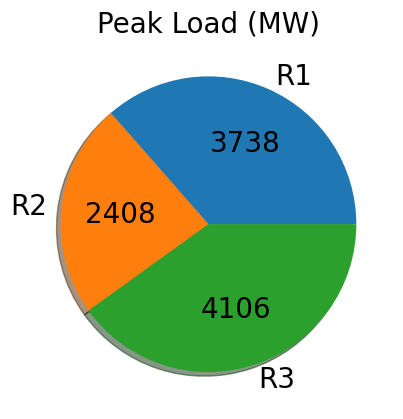

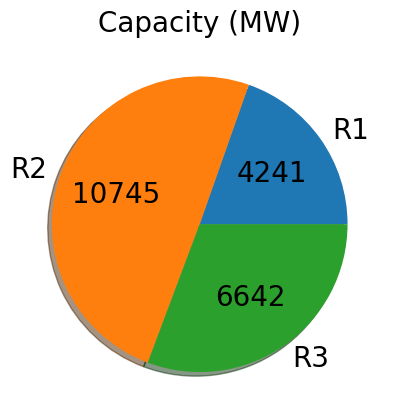

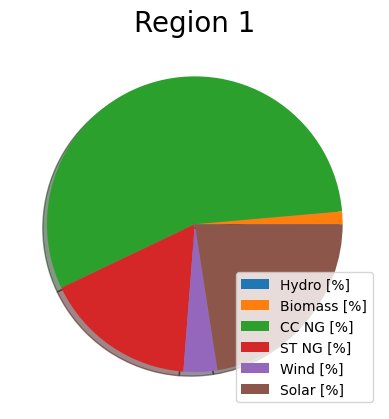

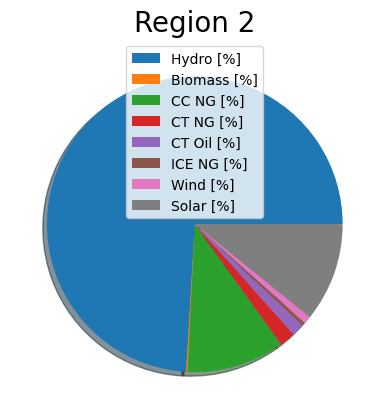

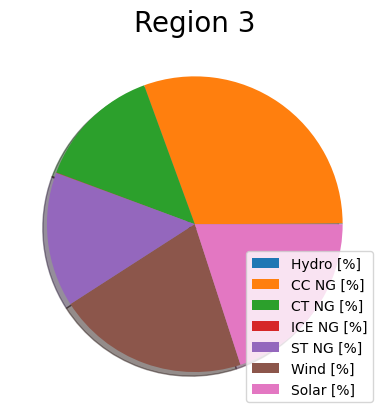

In [70]:
title='Peak Load (MW)'
y = regions_GC[title]
mylabels = regions_GC['Region']

pie_plot(y,mylabels,title,labels_flag=1)

title='Capacity (MW)'
y = regions_GC[title]
mylabels = regions_GC['Region']

pie_plot(y,mylabels,title,labels_flag=1)
types_of_gens=[i.replace('(MW)','[%]') for i in TOT_SG+CIG]
for r in range(1,len(reg_list)+1):
    title='Region '+str(r)
    y = regions_GC_gen_perc.loc[r-1,types_of_gens][regions_GC_gen_perc.loc[r-1,types_of_gens]!=0]
    mylabels = y.index
    
    pie_plot(y,mylabels,title,labels_flag=0)

In [71]:
Generators_GC

,Bus Name,BusNum,Region,Biomass (MW),CC NG (MW),CT NG (MW),CT Oil (MW),Geo (MW),Hydro (MW),ICE NG (MW),Solar (MW),ST Coal (MW),ST NG (MW),ST Other (MW),Wind (MW),NRES_SG,RES_SG,Pmax_TOT_SG,Pmax_CIG,Pmax_TOT
0,TWINBRCH,12.0,R1,58.25,1642.78,0.00,0.0,0.0,0.00,0.00,6.66,0.0,0.00,0.0,0.0,1642.78,58.25,1701.03,6.66,1707.69
1,LINCOLN,19.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,124.80,0.0,62.60,0.0,0.0,62.60,0.00,62.60,124.80,187.40
2,DEERCRK,31.0,R1,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,156.2,0.00,0.00,0.00,156.20,156.20
3,DELAWARE,32.0,R1,0.00,0.00,0.00,0.0,0.0,0.80,0.00,751.61,0.0,0.00,0.0,0.0,0.00,0.80,0.80,751.61,752.41
4,ROCKHILL,34.0,R2,16.50,27.00,0.00,0.0,0.0,16.90,8.40,129.16,0.0,0.00,0.0,0.0,35.40,33.40,68.80,129.16,197.96
5,STERLING,36.0,R2,0.00,71.51,82.40,0.0,0.0,47.10,0.00,0.00,0.0,0.00,0.0,59.5,153.91,47.10,201.01,59.50,260.51
6,WEST END,40.0,R2,0.00,0.00,54.00,0.0,0.0,0.00,0.00,95.00,0.0,0.00,0.0,0.0,54.00,0.00,54.00,95.00,149.00
7,W.LANCST,46.0,R2,0.00,150.00,0.00,0.0,0.0,96.26,0.00,244.40,0.0,0.00,0.0,0.0,150.00,96.26,246.26,244.40,490.66
8,PHILO,49.0,R2,0.00,262.95,50.40,0.0,0.0,82.00,0.00,350.97,0.0,0.00,0.0,0.0,313.35,82.00,395.35,350.97,746.32
9,TORREY,54.0,R2,0.00,0.00,0.00,142.4,0.0,0.00,0.00,264.47,0.0,0.00,0.0,0.0,142.40,0.00,142.40,264.47,406.87


## Summary
### NREL System

In [72]:
regions

,Region,N_gens,Capacity (MW),Buses list,Num Bus,Peak Load (MW),Min Load (MW),NRES_SG [MW],RES_SG [MW],CIG [MW],NRES_SG [%],RES_SG [%],CIG [%],TOT_SG [%]
0,R1,136.0,10522.99,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",42.0,9276.327882,4228.311838,8929.07,59.05,1534.87,84.852974,0.561152,14.585873,85.414127
1,R2,72.0,21437.50,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...",48.0,4803.546377,1190.362815,2311.16,18681.97,444.37,10.780921,87.146216,2.072863,97.927137
2,R3,119.0,8557.63,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...",28.0,5290.274654,1715.314180,5967.03,46.17,2544.43,69.727600,0.539519,29.732882,70.267118


## Our System

In [93]:
regions_GC=regions_GC[regions.columns]
regions_GC

,Region,N_gens,Capacity (MW),Buses list,Num Bus,Peak Load (MW),Min Load (MW),NRES_SG [MW],RES_SG [MW],CIG [MW],NRES_SG [%],RES_SG [%],CIG [%],TOT_SG [%]
0,R1,11.0,4161.04,"[12, 19, 31, 32, 70, 72, 73, 113]",8.0,3668.080210,1671.974856,3069.38,59.05,1032.61,73.764732,1.419116,24.816152,75.183848
1,R2,24.0,9784.04,"[34, 36, 40, 46, 49, 54, 59, 65, 76, 77, 80]",11.0,2192.330724,543.279645,1518.66,7975.91,289.47,15.521809,81.519597,2.958594,97.041406
2,R3,20.0,5654.06,"[85, 89, 90, 92, 100, 105, 107, 110, 112]",9.0,3495.305395,1133.314866,3919.63,6.00,1728.43,69.324167,0.106118,30.569715,69.430285


## Create OperationData excel

In [126]:
T_Loads=Buses.query('Load_Participation_Factor !=00')
T_Loads['Load_Participation_Factor']=T_Loads['Load_Participation_Factor']/3
T_Buses=Buses[['Bus Name','Region']]

The columns Bus Name BusNum Pmax_TOT_SG	Pmax_CIG	Pmax_TOT are used in the OperationData_IEEE_118bus.xslx Generators sheet.
Using these values, the following data are obtained:
- Snom = Pmax/0.95
- Pmin = Snom*0.2
- Qmax = 0.33*Pmax
- Qmin = -0.33*Pmax

In [127]:
T_Gen=Generators_GC[['BusNum','Pmax_CIG']]
T_Gen['BusName']=Generators_GC[['Bus Name']]
T_Gen['Pmax_SG']=Generators_GC['Pmax_TOT_SG']
T_Gen['Pmax']=np.array(T_Gen[['Pmax_SG']])+np.array(T_Gen[['Pmax_CIG']])
T_Gen['Snom']=T_Gen['Pmax']/0.95
T_Gen['Snom_SG']=T_Gen['Pmax_SG']/0.95
T_Gen['Snom_CIG']=T_Gen['Pmax_CIG']/0.95
T_Gen['Pmin']=T_Gen['Snom']*0.2
T_Gen['Pmin_SG']=T_Gen['Snom_SG']*0.2
T_Gen['Pmin_CIG']=T_Gen['Snom_CIG']*0.2
T_Gen['Qmax']=T_Gen['Pmax']*0.33
T_Gen['Qmin']=-T_Gen['Pmin']*0.33
T_Gen['Region']=Generators_GC['Region']

columns_order=['BusName','BusNum','Snom_SG','Snom_CIG','Snom','Pmax','Pmin','Qmax','Qmin','Region','Pmax_SG','Pmax_CIG','Pmin_SG','Pmin_CIG']

T_Gen=T_Gen[columns_order]
T_Gen

,BusName,BusNum,Snom_SG,Snom_CIG,Snom,Pmax,Pmin,Qmax,Qmin,Region,Pmax_SG,Pmax_CIG,Pmin_SG,Pmin_CIG
0,TWINBRCH,12.0,1790.557895,0.000000,1790.557895,1701.03,358.111579,561.3399,-118.176821,R1,1701.03,0.00,358.111579,0.000000
1,LINCOLN,19.0,65.894737,131.368421,197.263158,187.40,39.452632,61.8420,-13.019368,R1,62.60,124.80,13.178947,26.273684
2,DEERCRK,31.0,0.000000,164.421053,164.421053,156.20,32.884211,51.5460,-10.851789,R1,0.00,156.20,0.000000,32.884211
3,DELAWARE,32.0,0.842105,791.168421,792.010526,752.41,158.402105,248.2953,-52.272695,R1,0.80,751.61,0.168421,158.233684
4,ROCKHILL,34.0,72.421053,0.000000,72.421053,68.80,14.484211,22.7040,-4.779789,R2,68.80,0.00,14.484211,0.000000
5,STERLING,36.0,211.589474,0.000000,211.589474,201.01,42.317895,66.3333,-13.964905,R2,201.01,0.00,42.317895,0.000000
6,WEST END,40.0,56.842105,0.000000,56.842105,54.00,11.368421,17.8200,-3.751579,R2,54.00,0.00,11.368421,0.000000
7,W.LANCST,46.0,259.221053,0.000000,259.221053,246.26,51.844211,81.2658,-17.108589,R2,246.26,0.00,51.844211,0.000000
8,PHILO,49.0,416.157895,0.000000,416.157895,395.35,83.231579,130.4655,-27.466421,R2,395.35,0.00,83.231579,0.000000
9,TORREY,54.0,149.894737,278.389474,428.284211,406.87,85.656842,134.2671,-28.266758,R2,142.40,264.47,29.978947,55.677895


In [128]:
path='C:\\Users\Francesca\miniconda3\envs\gridcal_original\stability_analysis\stability_analysis\data\cases'
with pd.ExcelWriter(path+'/OperationData_IEEE_118_nomissingcig.xlsx', engine='openpyxl') as writer:
    T_Loads.to_excel(writer, sheet_name='Loads', index=False)
    T_Buses.to_excel(writer, sheet_name='Buses', index=False)
    T_Gen.to_excel(writer, sheet_name='Generators', index=False)